
### VQE custom implementation


In [2]:
from math import pi
from typing import Dict, Any

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.providers.aer import AerSimulator

from qiskit.visualization import plot_histogram

from src.utils.ising import IsingModel
from src.utils.vqe import create_circ, qc_eval, obj_func

In [ ]:
# Use Aer's qasm_simulator
simulator_method = 'automatic'
simulator = AerSimulator()
# define circuit params 
num_qubits = 4
circ_depth = 1
# number circuit evaluations
shots = 64
num_param = num_qubits * (circ_depth + 1)

# define initial point
rng = np.random.default_rng(seed=42)
thetas0 = rng.random(num_param) * pi #np.zeros((circ_depth + 1, num_param // (circ_depth + 1)))
# define specific optimizer
method = 'COBYLA'
# set maximum optimizer steps
maxiter = 10
# alpha-th quantile to evaluate the loss
alpha = 25

In [ ]:
# define a ferro ising model
# with uniform external field
J=1
h=0.05*J

# hamiltonian is defined with +
# following http://spinglass.uni-bonn.de/ notation 
adja_dict = {}
field = np.zeros(num_qubits)
ext_field = h
for i in range(num_qubits):
    field[i] = ext_field
    if i == num_qubits - 1:
        continue
    adja_dict[(i, i+1)] = -J
# class devoted to set the couplings and get the energy 
ising = IsingModel(num_qubits, dim=1, adja_dict=adja_dict, ext_field=field)
print(ising.AdjaDict, ising.ExtField)

In [ ]:
qc = create_circ(thetas0, num_qubits, circ_depth)
# Draw the circuit
qc.draw()

In [ ]:
counts = qc_eval(qc, simulator, shots)
plot_histogram(counts)

In [ ]:
# test objective function
loss0 = obj_func(thetas0, simulator, num_qubits, circ_depth, shots, ising, alpha=alpha, verbose=True)
print(f"\nLoss at step 0 -> {loss0}")

In [ ]:
res = minimize(obj_func, thetas0, args=(simulator, num_qubits, circ_depth, shots, ising, alpha, True), 
               method=method, options={'maxiter': maxiter, 'disp':True})

In [ ]:
thetas_opt  = res.x
qc = create_circ(thetas_opt, num_qubits, circ_depth)
counts = qc_eval(qc, simulator, shots)
plot_histogram(counts)

ridefinire time to solution
in lidar loro trovano l'ottimo per ogni N numero di istanze parallele
carleo non-stoquastic QA con troyer

Noi geralizziamo facendo una funzione in 2D oppure numero di shots come parametro t in modo fa fare una famiglia di funzioni

Cosa vogliamo: resolurce to solution, moltiplico N_shot e N_step
ferromagnetico bias
mi servono alcuni for
- random su theta
- scalo su shots 
- scalo su step (maxiter)

alpha suggerito da loro (0.25)

valuto con RTS (TTS dove moltiplico per gli shots) non normalizzato per n_max

n.b. green quantum computing paper montangero

In [41]:
import numpy as np
from scipy.optimize import curve_fit
from math import ceil
from json import JSONEncoder
from matplotlib import pyplot as plt
from src.utils import collect_results, NumpyArrayEncoder

In [42]:
qubits = np.arange(4, 22, 2, dtype=int)
psucc, ts, shots, nfevs = collect_results(qubits)

directory: results/N4/
directory: results/N6/
directory: results/N8/
directory: results/N10/
directory: results/N12/
directory: results/N14/
directory: results/N16/
directory: results/N18/
directory: results/N20/


N=16, t=2, shots=2, nfev=1
N=18, t=2, shots=2, nfev=1
N=20, t=2, shots=2, nfev=1


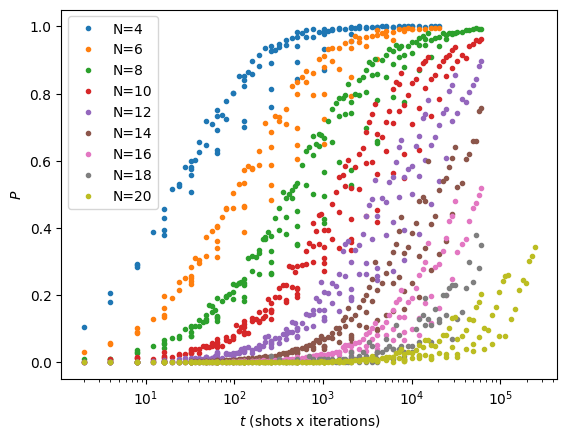

In [43]:
for i, (p,t) in enumerate(zip(psucc, ts)):
    if 4+i*2 > 14:
        last_zero = np.argwhere(np.isclose(p, 0.))
        print(f"N={4+i*2}, t={t[p==0.]}, shots={shots[i][p==0.]}, nfev={nfevs[i][p==0.]}")
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    plt.plot(p_t[0], p_t[1], ".", label=f"N={4+i*2}")

    plt.xscale('log')
    plt.xlabel(r"$t$ (shots x iterations)")
    plt.ylabel(r"$P$")
    plt.legend()
    plt.savefig("p_t_n4-18.png")

In [44]:
def running_mean(x, n):
    cumsum = np.cumsum(np.pad(x, int(ceil(n/2)), mode='reflect')) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

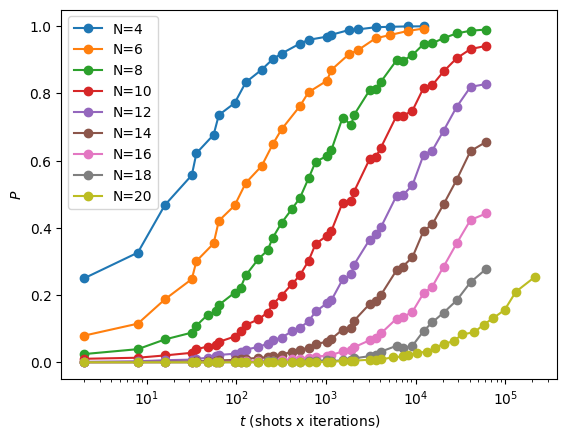

In [45]:
for i, (p,t) in enumerate(zip(psucc, ts)):
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    len_window = 12
    #p_t[1] = np.convolve(p_t[1], np.ones(len_window) / len_window, mode='same')
    p_t[1] = running_mean(p_t[1], len_window)
    plt.plot(p_t[0][::5], p_t[1][::5], "o-", label=f"N={4+i*2}")

    plt.xscale('log')
    plt.xlabel(r"$t$ (shots x iterations)")
    plt.ylabel(r"$P$")
    plt.legend()
    plt.savefig("p_t_n4-18.png")

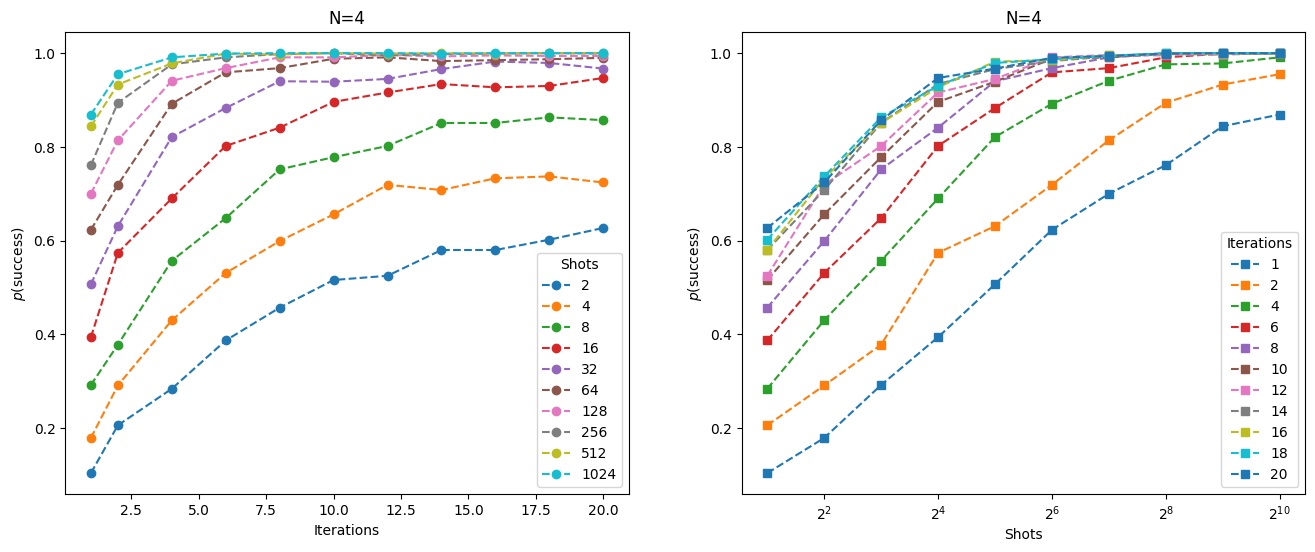

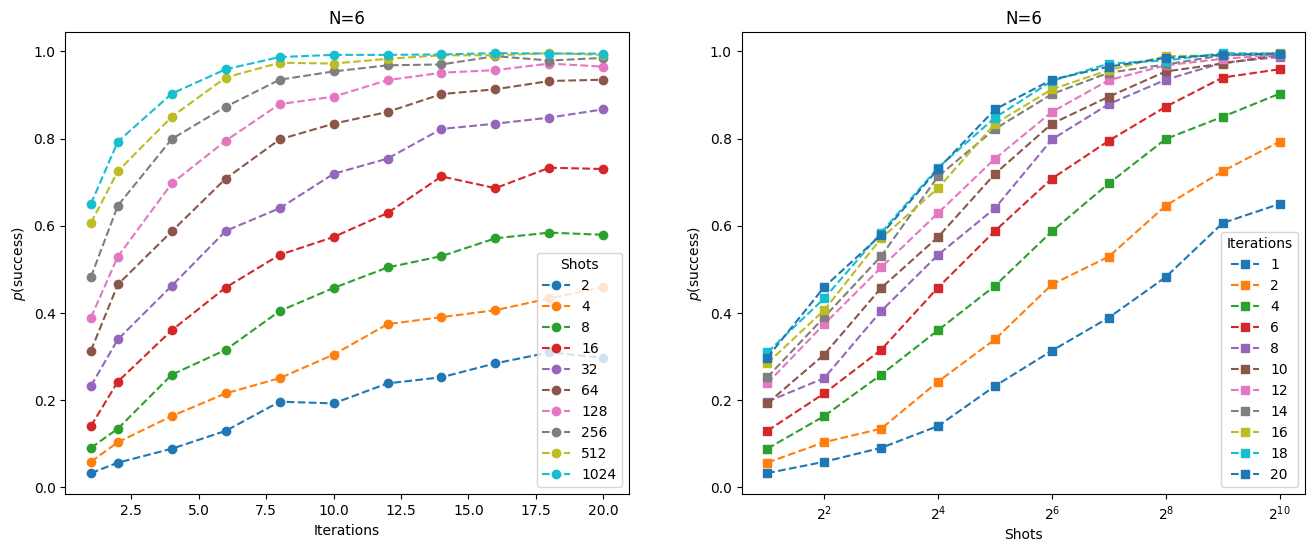

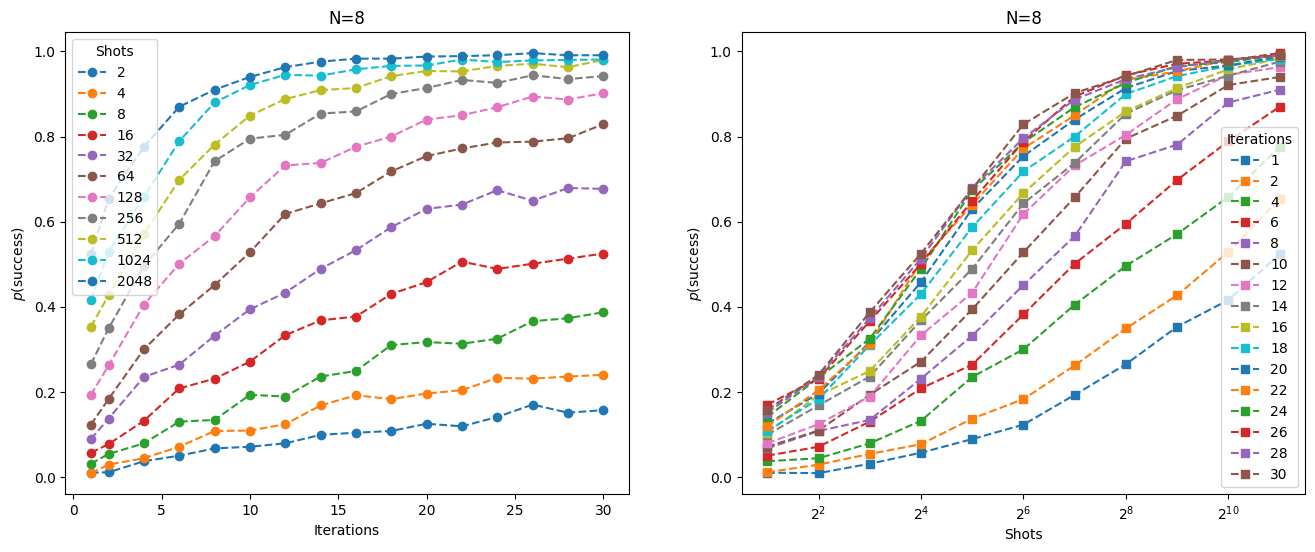

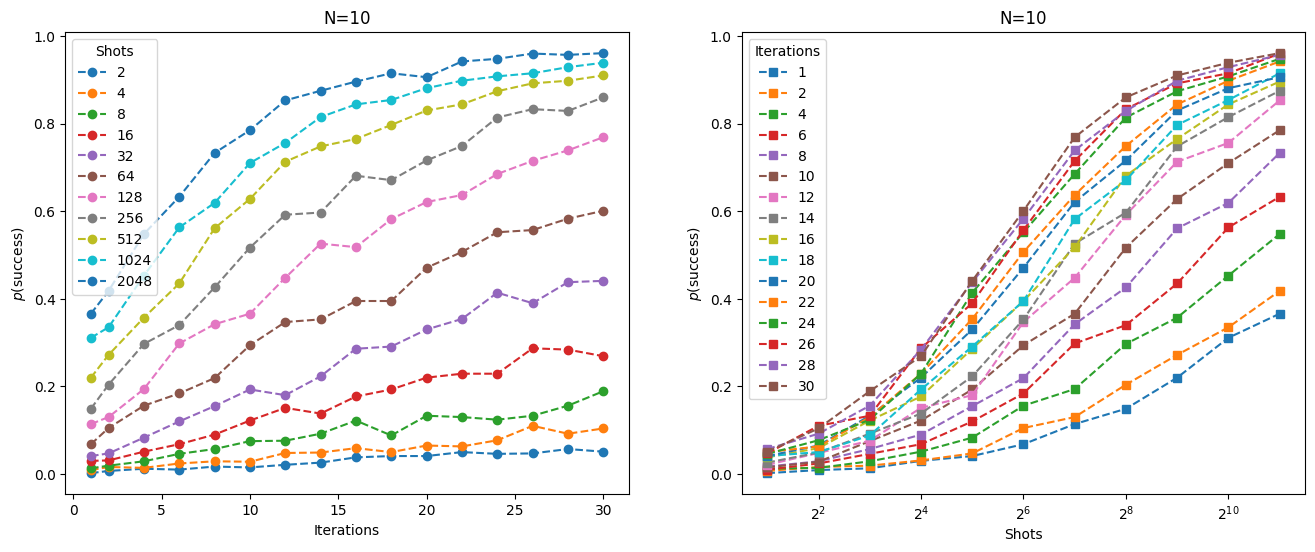

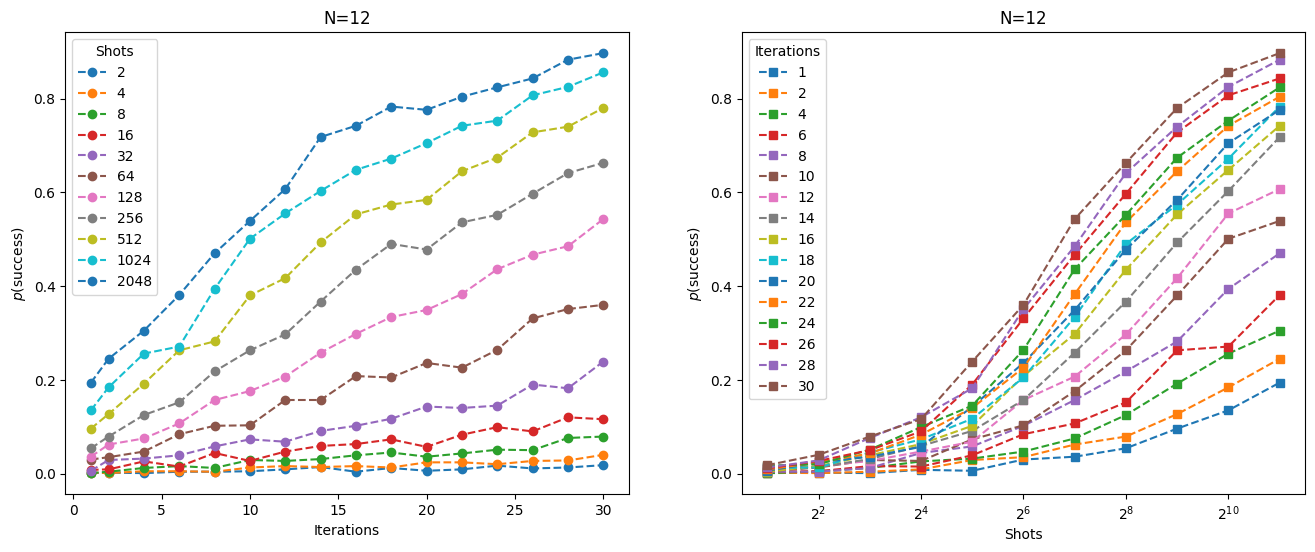

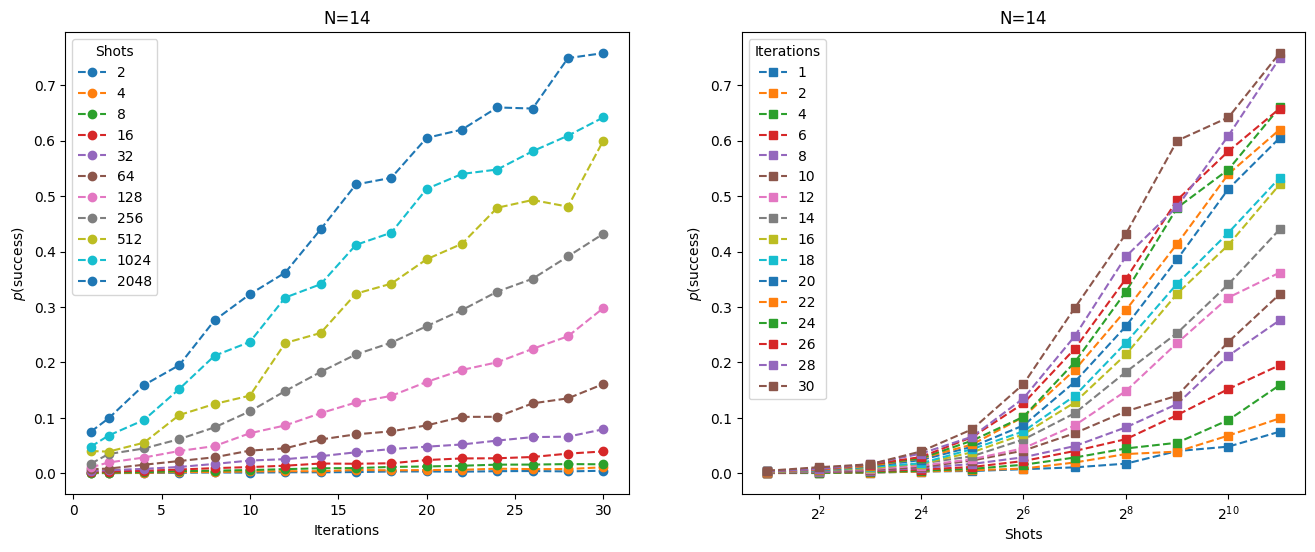

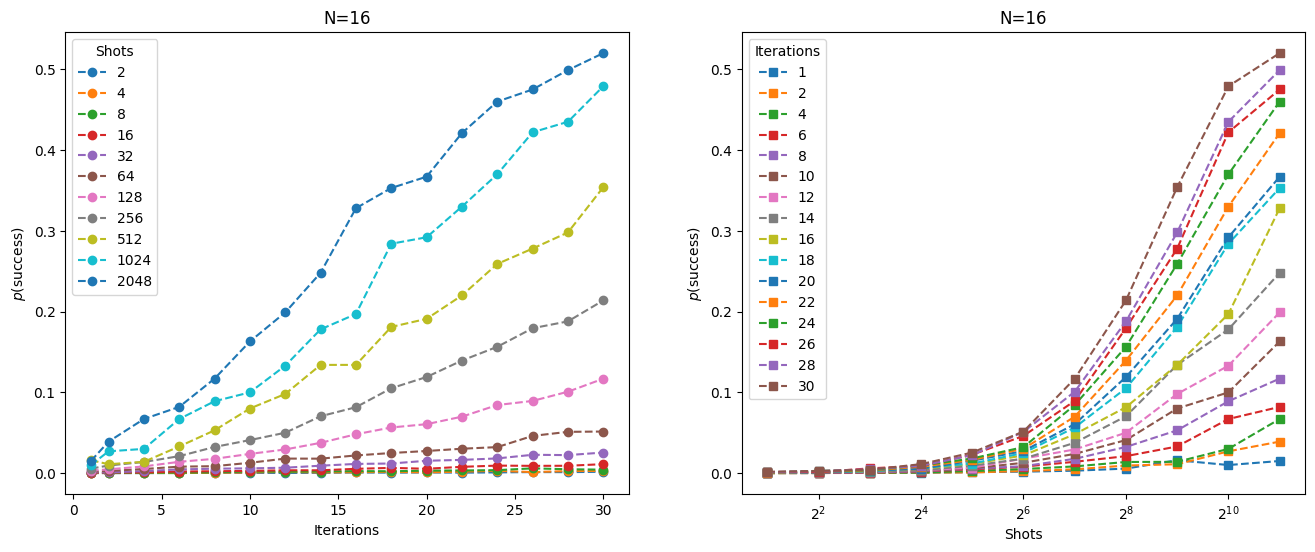

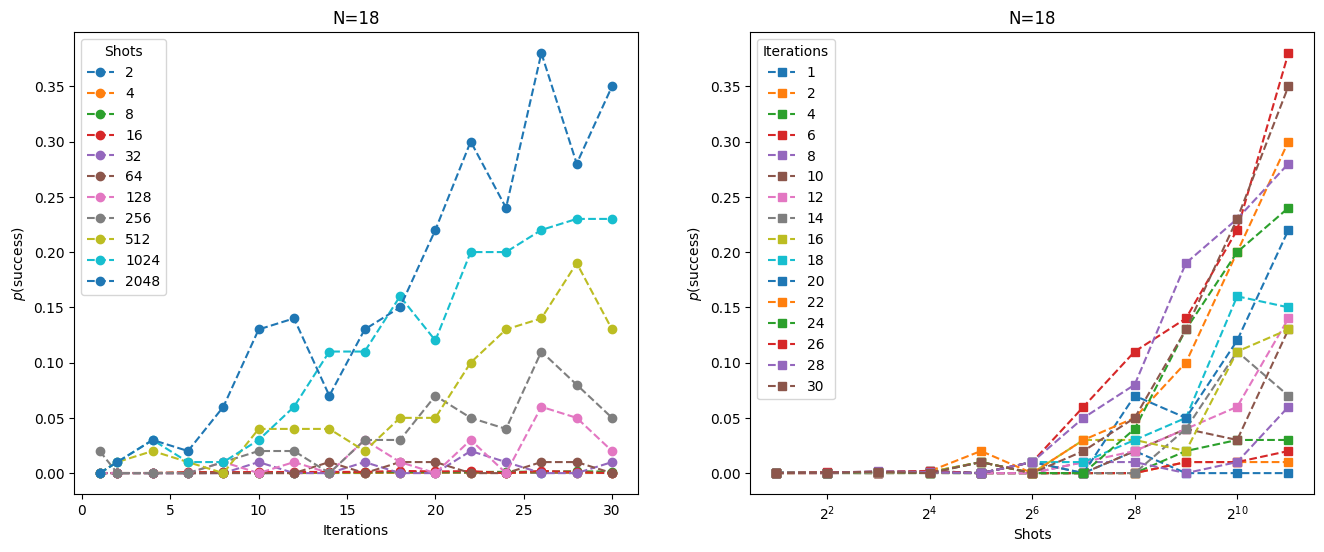

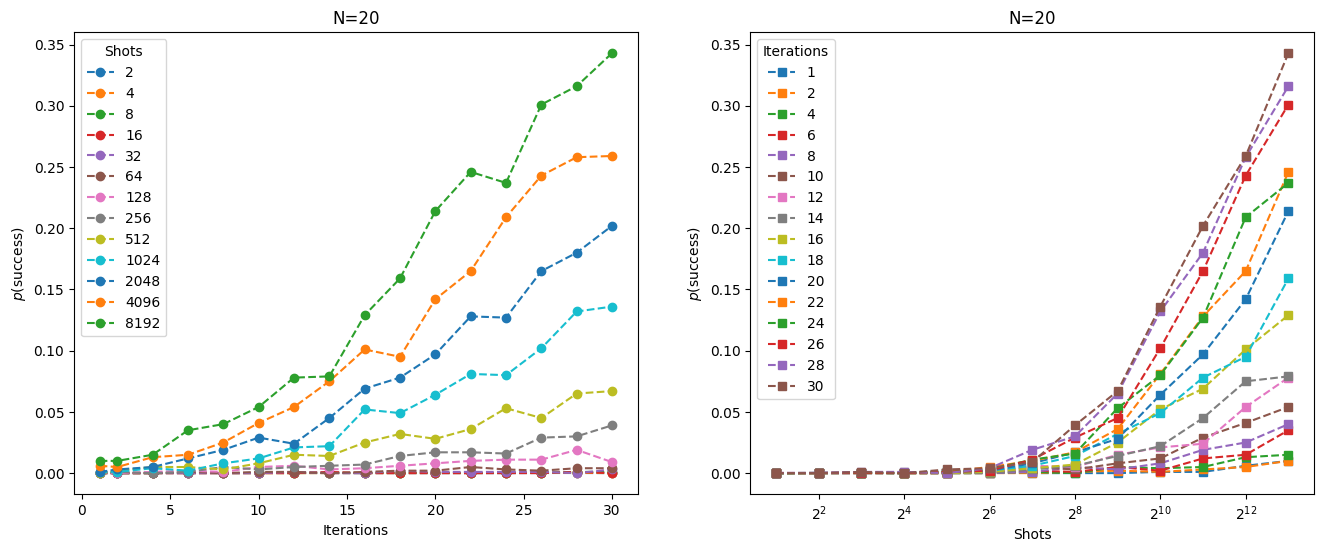

In [46]:
for k, (p,s,nfev) in enumerate(zip(psucc, shots, nfevs)):
    len_iter = np.max(nfev)//2+1

    p = np.reshape(p, (-1,len_iter))
    s = np.reshape(s, (-1,len_iter))
    nfev = np.reshape(nfev, (-1,len_iter))

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
    for i in range(p.shape[0]):
        ax1.plot(nfev[i,:], p[i,:], '--o', label=s[i,0])
    for j in range(p.shape[1]):
        ax2.plot(s[:,j], p[:,j], '--s', label=nfev[0,j])

    ax1.set_xlabel('Iterations')
    ax1.set_ylabel(r'$p$(success)')
    #ax1.set_ylim(0,1.1)

    ax2.set_xlabel('Shots')
    ax2.set_xscale('log', base=2)
    ax2.set_ylabel(r'$p$(success)')
    #ax2.set_ylim(0,1.1)

    ax1.legend(title='Shots')
    ax2.legend(title='Iterations')

    ax1.set_title(f'N={4+k*2}')
    ax2.set_title(f'N={4+k*2}')

    plt.savefig(f'shots_iter_N{4+k*2}.png')

In [47]:
def compute_r(p_s, p_d=0.99):
    rt = np.log(1-p_d)
    rt /= np.log(1-p_s)
    return rt

tts_list = []
for p,t in zip(psucc, ts):
    p = np.asarray(p)
    t = np.asarray(t)
    #print(p.shape,t.shape)
    mask =  p == 0.
    mask += p == 1. # mask += p == 1.
    #p[mask] = 0.00005
    p = np.delete(p, mask)
    t = np.delete(t, mask)

    rt = compute_r(p)
    tts_list.append(t*rt)

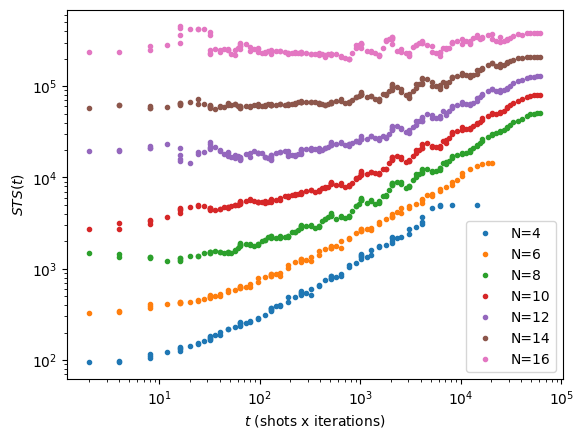

In [60]:
for i, (tts,t) in enumerate(zip(tts_list, ts)):
    if 4+i*2 > 16:
        continue
    t = np.asarray(t)
    mask = np.asarray(psucc[i]) == 0.
    mask += np.asarray(psucc[i]) == 1. # mask += np.asarray(psucc[i]) == 1.
    t = np.delete(t, mask)

    tts_t = np.vstack((t, tts))
    tts_t = tts_t[:, np.argsort(tts_t[0, :])]
    # roll-mean
    len_window = 8
    tts_t[1] = running_mean(tts_t[1], len_window)
    plt.plot(tts_t[0], tts_t[1], ".", label=f"N={4+i*2}")

    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(1.5,50000)
    #plt.ylim(10000, 500000)
    plt.xlabel(r"$t$ (shots x iterations)")
    plt.ylabel(r"$STS(t)$")
    plt.legend()
    plt.savefig("STS-t_roll8.png")

In [19]:
def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

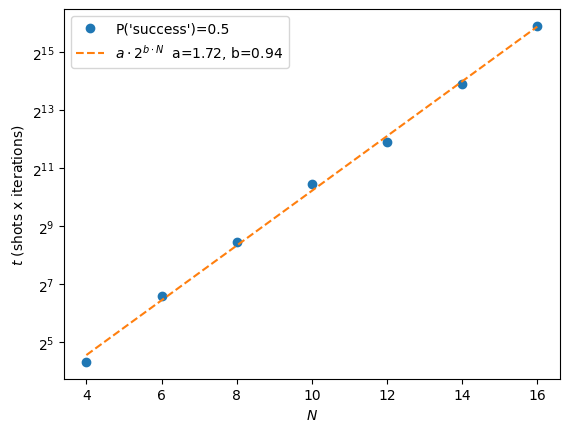

In [25]:
pt_all = []
for i, (p,t) in enumerate(zip(psucc, ts)):
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    pt_all.append(p_t)

min_psucc = 0.5
step_size = []
for i, pt in enumerate(pt_all):
    mask = pt[1] >= min_psucc
    if mask.sum() == 0:
        continue
    step_size.append(pt[0][mask][0])

x_axes = 4 + 2*np.arange(len(step_size))

popt, _ = curve_fit(fun_lin, x_axes, np.log2(step_size))
plt.plot(x_axes, step_size, "o", label=f"P('success')={min_psucc}")
plt.plot(np.arange(4,17), fun_exp(np.arange(4,17), 2**popt[0], popt[1]), "--", label=r"$a \cdot 2^{b \cdot N}$" + f"  a={2**popt[0]:.2f}, b={popt[1]:.2f}")

plt.yscale('log', base=2)
plt.ylabel(r"$t$ (shots x iterations)")
plt.xlabel(r"$N$")

plt.legend()

plt.savefig("minit-succ50.png")

In [1]:
from src.utils import param_circ

num_qubits = 4
num_layer = 2

circ = param_circ(num_qubits, num_layer)

print(circ)
#circ.num_parameters / circ.num_qubits - 1

        ┌──────────────┐ ░                      ░ ┌──────────────┐ ░           »
   q_0: ┤ Ry(theta[0]) ├─░───■──────────────■───░─┤ Ry(theta[4]) ├─░───■───────»
        ├──────────────┤ ░ ┌─┴─┐            │   ░ ├──────────────┤ ░ ┌─┴─┐     »
   q_1: ┤ Ry(theta[1]) ├─░─┤ X ├──■─────────┼───░─┤ Ry(theta[5]) ├─░─┤ X ├──■──»
        ├──────────────┤ ░ └───┘┌─┴─┐       │   ░ ├──────────────┤ ░ └───┘┌─┴─┐»
   q_2: ┤ Ry(theta[2]) ├─░──────┤ X ├──■────┼───░─┤ Ry(theta[6]) ├─░──────┤ X ├»
        ├──────────────┤ ░      └───┘┌─┴─┐┌─┴─┐ ░ ├──────────────┤ ░      └───┘»
   q_3: ┤ Ry(theta[3]) ├─░───────────┤ X ├┤ X ├─░─┤ Ry(theta[7]) ├─░───────────»
        └──────────────┘ ░           └───┘└───┘ ░ └──────────────┘ ░           »
meas_0: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
meas_1: ═══════════════════════════════════════════════════════════════════════»
                            

In [5]:
from qiskit.circuit.library import  RealAmplitudes

qc = RealAmplitudes(num_qubits, reps=num_layer, insert_barriers=True, entanglement='circular')
qc.measure_all()

print(qc.decompose())

        ┌──────────┐ ░ ┌───┐                ░ ┌──────────┐ ░ ┌───┐          »
   q_0: ┤ Ry(θ[0]) ├─░─┤ X ├──■─────────────░─┤ Ry(θ[4]) ├─░─┤ X ├──■───────»
        ├──────────┤ ░ └─┬─┘┌─┴─┐           ░ ├──────────┤ ░ └─┬─┘┌─┴─┐     »
   q_1: ┤ Ry(θ[1]) ├─░───┼──┤ X ├──■────────░─┤ Ry(θ[5]) ├─░───┼──┤ X ├──■──»
        ├──────────┤ ░   │  └───┘┌─┴─┐      ░ ├──────────┤ ░   │  └───┘┌─┴─┐»
   q_2: ┤ Ry(θ[2]) ├─░───┼───────┤ X ├──■───░─┤ Ry(θ[6]) ├─░───┼───────┤ X ├»
        ├──────────┤ ░   │       └───┘┌─┴─┐ ░ ├──────────┤ ░   │       └───┘»
   q_3: ┤ Ry(θ[3]) ├─░───■────────────┤ X ├─░─┤ Ry(θ[7]) ├─░───■────────────»
        └──────────┘ ░                └───┘ ░ └──────────┘ ░                »
meas_0: ════════════════════════════════════════════════════════════════════»
                                                                            »
meas_1: ════════════════════════════════════════════════════════════════════»
                                                                

In [34]:
from qiskit.providers.aer import AerSimulator

sim = AerSimulator(
            method='automatic',
            max_parallel_threads=1,
        )

In [28]:
from qiskit.providers.fake_provider import FakeVigo
from qiskit_aer.noise import NoiseModel

device_backend = FakeVigo()
noise_model = NoiseModel.from_backend(device_backend)
#sim.set_options(noise_model=noise_model)

In [53]:
from qiskit.providers.aer import AerProvider

prov = AerProvider()
prov.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

In [34]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt

from qiskit import IBMQ, transpile
from qiskit.providers.aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.circuit.library import RealAmplitudes
from qiskit.visualization import plot_histogram


# get a real backend from a real provider
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-11-16 18:20:20,064: Credentials are already in use. The existing account in the session will be replaced.


In [39]:
#print(provider.backends())
backend = provider.get_backend('ibmq_lima')
noise_model = NoiseModel.from_backend(backend)

simulator = AerSimulator(
            method='statevector',
            max_parallel_threads=1,
            noise_model = noise_model, 
        )

exact_sim = AerSimulator(
            method='statevector',
            max_parallel_threads=1,
        )
# generate a simulator that mimics the real quantum system with the latest calibration results

qubits = 6
circ_depth = 1 
# create the circuit
# standard VQE ansatz
qc = RealAmplitudes(
    qubits,
    reps=circ_depth,
    insert_barriers=True,
    entanglement="circular",
)
# measure all qubits at the end of the circuit
qc.measure_all()
params = np.zeros(qc.num_parameters) #np.random.uniform(-2 * pi, 2 * pi, qc.num_parameters)
qc = qc.assign_parameters(params)

# Execute the circuit with fixed params
job = simulator.run(transpile(qc, simulator))
# Grab results from the job
result = job.result().get_counts()
# return counts
plot_histogram(result, filename='noisy_sim.png')

In [40]:
# Execute the circuit with fixed params
job = exact_sim.run(transpile(qc, exact_sim))
# Grab results from the job
result = job.result().get_counts()
# return counts
plot_histogram(result, filename='exact_sim.png')

TODO

- aumentare le iterazioni per migliorare la stima 
- rifare N=18
- moltiplico step e iteration ma mantengo il colore per ogni size ho un valore e quindi un plot per tutte le taglie (size scaling) salvare la migliore energia che trovo e quando la trovo.